In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)

import blitzgsea as blitz


# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


In [3]:
random.seed(18)
seed = random.random()
print(random.random())

0.6614305484952444


In [4]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - MoTrPAC_2023
16 - Kinase_Perturbations_from_GEO_down
17 - Disease_Signatures_from_GEO_down_2014
18 - Disease_Perturbations_from_GEO_up
19 - Old_CMAP_down
20 - MCF7_Perturbations_from_GEO_up
21 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - PPI_Hub_Proteins
24 - Disease_Signatures_from_GEO_up_2014
25 - GTEx_Tissue_Expression_Up
26 - L1000_Kinase_a

In [5]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("Reactome_2022")

In [6]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.parquet").resolve()
signature = pd.read_parquet(gene_weight_dir)
print(signature.shape)
signature.head()

(2718, 73)


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,AAAS,-0.029648,0.070605,-0.142056,-0.136777,-0.222449,0.025861,-0.036514,0.015436,0.049837,...,0.074131,0.003742,0.013311,-0.034091,0.036546,0.042408,-0.015514,0.078286,-0.008753,-0.023630
1,AAMP,0.139939,0.053766,-0.038851,-0.055015,0.103119,-0.003519,0.067513,0.038110,-0.159354,...,0.091614,0.026098,0.007294,0.054157,-0.018419,0.085175,-0.025353,0.031713,0.105514,-0.009389
2,AARS1,-0.029446,-0.005102,0.023082,0.059505,0.032885,-0.050433,-0.160086,-0.076602,0.286948,...,-0.053943,-0.008631,-0.021420,-0.003622,0.015946,0.117308,0.120526,0.122062,-0.048667,0.083917
3,AARS2,0.347551,0.120056,-0.306340,-0.196994,0.047495,0.293353,0.267543,0.427548,-0.107472,...,0.038747,-0.082284,0.025216,0.054058,-0.022778,0.163873,-0.009841,-0.025877,0.028444,-0.027354
4,AASDHPPT,0.264927,0.243652,-0.088062,0.043917,-0.105922,0.283789,0.164702,0.165618,0.019526,...,-0.139645,0.004266,-0.100743,-0.103351,0.045809,-0.000606,-0.033179,-0.072038,0.037288,-0.029683


In [7]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library, seed=seed)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [8]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library, seed=seed)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [9]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results['source'] = 'real'
neg_GSEA_results['source'] = 'negative control'

combo_gsea_df = pd.concat([all_GSEA_results, neg_GSEA_results])

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.parquet.gz")
combo_gsea_df.to_parquet(combo_gsea_dir, compression = 'gzip')


In [10]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
Term,,,,,,,,,
M Phase R-HSA-68886,-0.557011,-8.011102,1.136851e-15,1.180051e-12,1.180051e-12,199,"HAUS2,SGO1,CKAP5,PSMC2,PSMA2,TUBGCP2,NUP98,SEM...",z_14,real
Mitotic Metaphase And Anaphase R-HSA-2555396,-0.602681,-7.535685,4.857769e-14,5.042364e-11,2.521182e-11,147,"SGO1,CKAP5,PSMC2,PSMA2,NUP98,SEM1,CDC23,PSMD2,...",z_14,real
Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203,-0.625820,-7.518758,5.529917e-14,5.740053e-11,5.740053e-11,141,"POLR2D,NUP155,SNRPF,SRRT,U2AF2,SRSF3,SF3B5,LSM...",z_12,real
Mitotic Anaphase R-HSA-68882,-0.600761,-7.481033,7.374041e-14,7.654254e-11,2.551418e-11,146,"SPC24,PSMA4,ANAPC5,SGO1,CDC27,CKAP5,SMC3,NUP13...",z_14,real
Adaptive Immune System R-HSA-1280218,-0.521479,-7.444491,9.731866e-14,1.010168e-10,3.367226e-11,183,"PSMD3,SEC61G,PSMD11,HECTD1,KIF2C,RAB7A,MTOR,SE...",z_35,real
...,...,...,...,...,...,...,...,...,...
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.831122,8.014016,1.192650e-15,1.237971e-12,1.237971e-12,86,"ATP5F1B,NDUFAF5,NDUFV2,NDUFA6,CYCS,NDUFB2,NDUF...",z_28,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.793966,8.041400,9.512805e-16,9.874291e-13,9.874291e-13,86,"UQCRC2,NDUFB4,SCO2,NDUFB5,UQCRC1,COX18,NDUFAF3...",z_35,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.808322,8.209536,3.202183e-16,3.323865e-13,3.323865e-13,86,"UQCRFS1,NDUFA2,NDUFV2,OGDH,ATP5PB,ATP5F1A,NDUF...",z_7,real


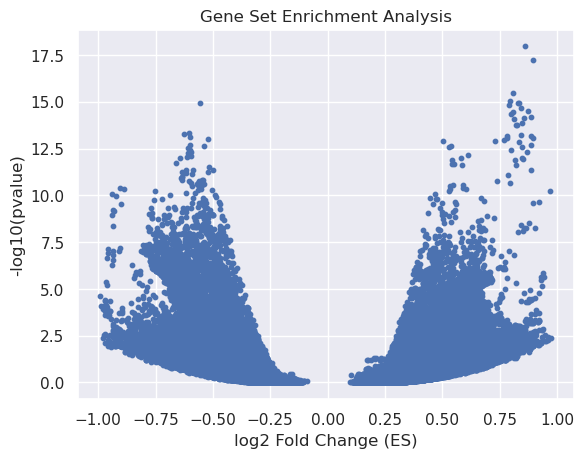

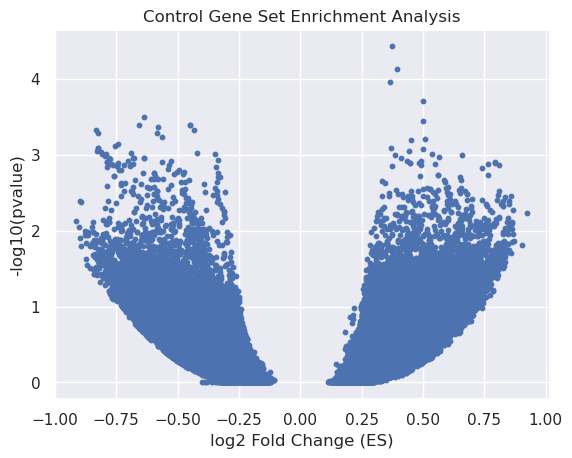

In [11]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

#save figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

#save figure
cgsea_save_path = pathlib.Path("../1.data-exploration/figures/controlgsea.png")
plt.savefig(cgsea_save_path, bbox_inches="tight", dpi=600)

In [12]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()